In [22]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import mlflow
import mlflow.sklearn

In [23]:
X_train = pd.read_csv('../data/X_train.csv')
X_test = pd.read_csv('../data/X_test.csv')
y_train = pd.read_csv('../data/y_train.csv').squeeze()
y_test = pd.read_csv('../data/y_test.csv').squeeze()

In [24]:
def evaluate(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"RMSE: {rmse:.2f}")
    print(f"R^2: {r2:.3f}")
    return rmse, r2

In [25]:
mlflow.set_tracking_uri("sqlite:///../mlruns.db")  # or local folder
mlflow.set_experiment("bixi_trip_duration_prediction")

<Experiment: artifact_location='file:C:/JUPYTER/bixi-mlops-project/notebooks/mlruns/1', creation_time=1752694751813, experiment_id='1', last_update_time=1752694751813, lifecycle_stage='active', name='bixi_trip_duration_prediction', tags={}>

###  Train & Log Random Forest

In [27]:
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns

In [28]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [29]:
# Create column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'  # Keep the rest of the columns
)

X_train_encoded = preprocessor.fit_transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

In [30]:
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train_encoded, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### Random Forest Run to MLflow

In [31]:
with mlflow.start_run():
    rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
    rf.fit(X_train_encoded, y_train)

    preds = rf.predict(X_test_encoded)
    rmse, r2 = evaluate(y_test, preds)

    # Log parameters
    mlflow.log_param("model_type", "RandomForest")
    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("max_depth", 10)

    # Log metrics
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)

    # Log model
    mlflow.sklearn.log_model(rf, artifact_path="model")

RMSE: 8.69
R^2: 0.461


2025/07/16 16:38:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


### Linear Regression (Baseline Model)

In [35]:
from sklearn.preprocessing import StandardScaler

# Fix: Set with_mean=False to avoid centering sparse matrix
scaler = StandardScaler(with_mean=False)

X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

In [37]:
import scipy.sparse

print(scipy.sparse.issparse(X_train_encoded))  # should print: True

True


In [39]:
from sklearn.preprocessing import StandardScaler
import scipy.sparse

In [40]:
# Check if your data is sparse
print(scipy.sparse.issparse(X_train_encoded))  # Should print True

True


In [41]:
# Apply StandardScaler with with_mean=False
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

In [42]:
from sklearn.linear_model import LinearRegression

In [43]:
with mlflow.start_run():
    # Initialize and train the model
    lr = LinearRegression()
    lr.fit(X_train_scaled, y_train)

    # Predict
    preds = lr.predict(X_test_scaled)

    # Evaluate
    rmse, r2 = evaluate(y_test, preds)

    # Log params and metrics to MLflow
    mlflow.log_param("model_type", "LinearRegression")
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)

    # Log model
    mlflow.sklearn.log_model(lr, artifact_path="model")

RMSE: 11.30
R^2: 0.090


2025/07/16 16:53:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


### Compare Models

### Model Performance Comparison

We evaluated two models on the task of predicting Bixi trip duration:

| Model               | RMSE  | R² Score |
|--------------------|-------|----------|
| Random Forest       | 8.69  | 0.461    |
| Linear Regression   | 11.30 | 0.090    |

- The Random Forest model clearly outperforms the baseline Linear Regression in both RMSE and R².
- Therefore, we will select the **Random Forest** model as our final candidate for deployment.


In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

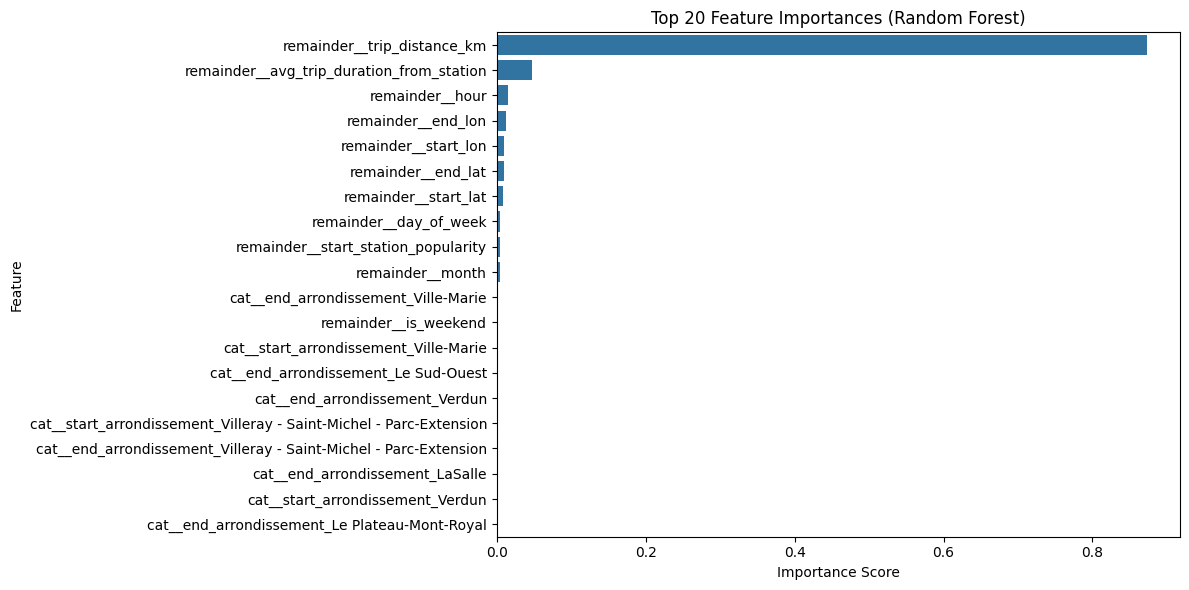

In [50]:
# Get feature importances from the trained model
importances = rf.feature_importances_

# Get feature names from the ColumnTransformer
# This extracts names from OneHotEncoder
feature_names = preprocessor.get_feature_names_out()

# Sort by importance
indices = np.argsort(importances)[::-1]

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=importances[indices][:20], y=feature_names[indices][:20])  # Top 20 features
plt.title("Top 20 Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

### Save Final Model

In [52]:
import joblib

In [54]:
joblib.dump(rf, '../model/best_model.pkl')

['../model/best_model.pkl']

In [55]:
import os

In [56]:
os.makedirs('../model', exist_ok=True)